In [1]:
import sys; sys.path.append("..") 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utility import loadfile, savefile, exists
from src.dataprocessing import *
from src import rnn

## load data

In [2]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [3]:
min_len = 100
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(f"{continuous_path}/cts_{min_len}/dataset {min_len}_{i}.csv"):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv', print_msg=False)
    cts_list.append(cts_df)
    i += 1

# data reshape

In [4]:
target_list = cts_list

# history size and future size
history_list = [10, 20, 30, 40]
future_list = [10, 20, 30]
step = 1

# variable selection
history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

# supervised attention factor
delta = 1
att_type = 'linear'
        
# test data split        
test_size = 0.2
test_num = -1

# model structure
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_list = ['seq2seq_gru', 'att_seq2seq_gru', 'datt_seq2seq_gru']

iteration_list = [x for x in range(1,6)]
i=0
for model_type in model_list:
    for future_size in future_list:
        for history_size in history_list:            
            for iteration in iteration_list:
                model_num = iteration
                model_name = f"{history_size}_{future_size}_{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"
                result = loadfile('./result', model_name, file_type='csv', header=1, print_msg=False)
                result.columns = ['R2_TT-3061-3', 'R2_TT-3061-5', 'R2_LT-3061-2', 'R2_MEAN', 'NRMSE_TT-3061-3', 'NRMSE_TT-3061-5', 'NRMSE_LT-3061-2', 'NRMSE_MEAN']
                time_steps = pd.DataFrame([f't+{i+1}' for i in range(future_size)]+['mean'], columns=['step'])
                result = pd.concat([result, time_steps], axis=1)
                result['future'] = future_size
                result['history'] = history_size
                if model_type == model_list[0]:
                    result['model'] = "Seq2Seq"
                elif model_type == model_list[1]:
                    result['model'] = "Attention-Seq2Seq"
                else:
                    result['model'] = "Dual-attention-Seq2Seq"
                result['iteration'] = iteration
                if not i:
                    result_reshape = result
                else:
                    result_reshape = pd.concat([result_reshape, result], axis=0)
                i += 1

# Figure

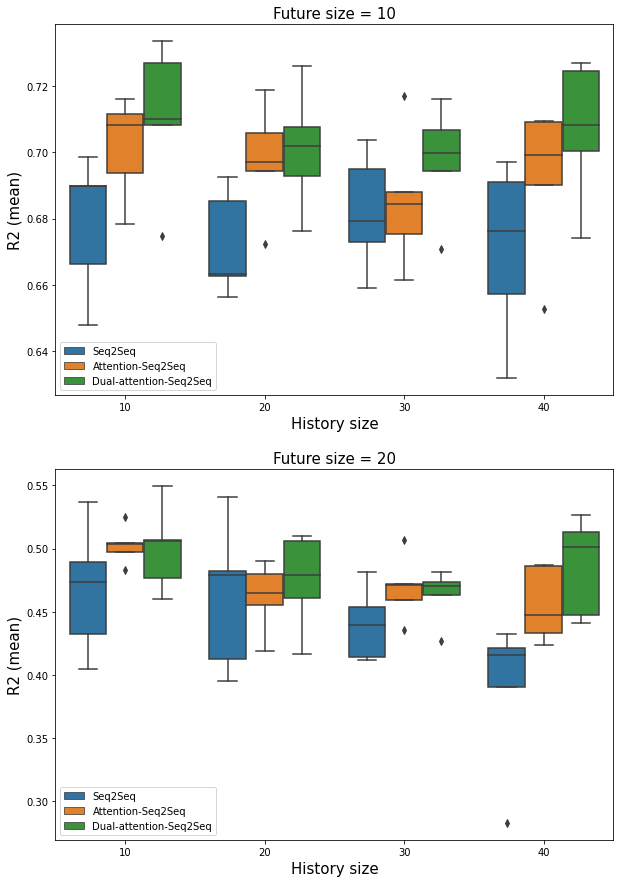

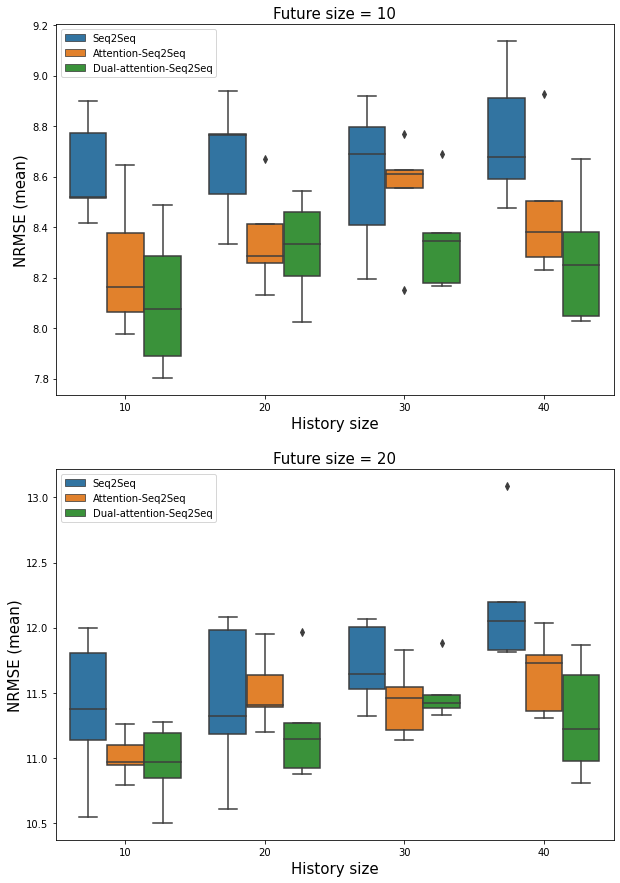

In [5]:
update = False
row_size = 10
column_size = 15

future_list = [10, 20]
data = result_reshape[result_reshape['step']=='mean']

plt.figure(figsize=(row_size,column_size))
for i, future_size in enumerate(future_list):
    plt.subplot(len(future_list), 1, i+1)
    plot_data = data[data['future']==future_size]
    sns.boxplot(x='history', y='R2_MEAN', hue='model', data=plot_data, notch=False, showfliers = True)
    plt.title(f"Future size = {future_size}", fontsize=15)
    plt.xlabel(f"History size", fontsize=15)
    plt.ylabel(f"R2 (mean)", fontsize=15)
    plt.legend(loc='lower left')
    
figure_name = f'figure1_model_comparison_r2'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()

future_list = [10, 20]
data = result_reshape[result_reshape['step']=='mean']

plt.figure(figsize=(row_size,column_size))
for i, future_size in enumerate(future_list):
    plt.subplot(len(future_list), 1, i+1)
    plot_data = data[data['future']==future_size]
    sns.boxplot(x='history', y='NRMSE_MEAN', hue='model', data=plot_data, notch=False, showfliers = True)
    plt.title(f"Future size = {future_size}", fontsize=15)
    plt.xlabel(f"History size", fontsize=15)
    plt.ylabel(f"NRMSE (mean)", fontsize=15)
    plt.legend(loc='upper left')
    
figure_name = f'figure1_model_comparison_nrmse'
if not exists(f'./figure/{figure_name}.png') or update:
    savefile(_, './figure', figure_name, 'figure')
    
plt.show()